In [1]:
from preamble import *

In [2]:
df = pd.read_csv('./data/j_weather_data_lstm_v2.csv', index_col=0)
print(type(df), df.shape)

<class 'pandas.core.frame.DataFrame'> (15739, 8)


In [3]:
df.head()

,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,outflow,input
datetime,,,,,,,,
2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,4672.98,6063.02
2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,6425.49,7195.35
2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,8620.11,7472.46
2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,8697.04,4809.88
2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,9543.70,6292.50


In [4]:
feature = df.reset_index()
# feature = df_reset.drop(columns=['output_flow'])
target = df['outflow'].values.reshape(-1, 1)
feature.shape, target.shape

((15739, 9), (15739, 1))

In [5]:
feature

,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,outflow,input
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,4672.98,6063.02
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,6425.49,7195.35
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,8620.11,7472.46
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,8697.04,4809.88
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,9543.70,6292.50
...,...,...,...,...,...,...,...,...,...
15734,2024-10-17 14:00:00,25.7,0.0,0.9,52.0,1013.3,0.0,11705.70,7130.56
15735,2024-10-17 15:00:00,26.0,0.0,0.2,47.0,1013.0,0.0,9027.35,6876.49
15736,2024-10-17 16:00:00,26.1,0.0,0.3,49.0,1012.8,0.0,8719.41,7014.71
15737,2024-10-17 17:00:00,25.3,0.0,0.2,51.0,1012.9,0.0,2606.70,2500.51


In [6]:
feature['datetime'] = pd.to_datetime(feature['datetime'])

In [7]:
import holidays

kr_holidays = holidays.KR()
feature['is_weekend'] = feature['datetime'].dt.dayofweek >= 5 | feature['datetime'].isin(kr_holidays)
feature.head()

,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,outflow,input,is_weekend
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,4672.98,6063.02,True
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,6425.49,7195.35,True
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,8620.11,7472.46,True
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,8697.04,4809.88,True
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,9543.70,6292.50,True


In [8]:
import torch
import torch.nn as nn

torch.__version__, torch.cuda.is_available()

('2.5.1', True)

In [9]:
train_size = int(feature.shape[0] * 0.7)

trainset_feature = feature[:train_size]
trainset_target = target[:train_size]
testset_feature = feature[train_size:]
testset_target = target[train_size:]
print(trainset_feature.shape, testset_feature.shape)

(11017, 10) (4722, 10)


In [10]:
def create_time_feature(df): 
  df['dayofmonth'] = df['datetime'].dt.day 
  df['dayofweek'] = df['datetime'].dt.dayofweek 
  df['quarter'] = df['datetime'].dt.quarter 
  df['month'] = df['datetime'].dt.month 
  df['year'] = df['datetime'].dt.year 
  df['dayofyear'] = df['datetime'].dt.dayofyear 
  df['week'] = df['datetime'].dt.isocalendar().week
  df['hour'] = df['datetime'].dt.hour
  df['minute'] = df['datetime'].dt.minute
  df['second'] = df['datetime'].dt.second
  return df

In [12]:
trainset_feature = create_time_feature(trainset_feature)
testset_feature = create_time_feature(testset_feature)

C:\Users\user\AppData\Local\Temp\ipykernel_17160\1880899018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofmonth'] = df['datetime'].dt.day
C:\Users\user\AppData\Local\Temp\ipykernel_17160\1880899018.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['datetime'].dt.dayofweek
C:\Users\user\AppData\Local\Temp\ipykernel_17160\1880899018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [14]:
trainset_feature.drop('datetime', axis=1, inplace=True)
testset_feature.drop('datetime', axis=1, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_17160\419025515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainset_feature.drop('datetime', axis=1, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17160\419025515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testset_feature.drop('datetime', axis=1, inplace=True)


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler_feature = MinMaxScaler()
train_feature_scaled = scaler_feature.fit_transform(trainset_feature)
test_feature_scaled = scaler_feature.transform(testset_feature)

scaler_target = MinMaxScaler()
train_target_scaled = scaler_target.fit_transform(trainset_target)
test_target_scaled = scaler_target.transform(testset_target)

In [17]:
from tqdm import tqdm

def split_dataset(data, target, seq_len):
  X, y  = [], []
  for i in tqdm(range(data.shape[0]-(seq_len))):
    X.append(data[i:i+seq_len, :]) 
    y.append(target[i+seq_len])
  return np.array(X), np.array(y)

seq_len = 60

In [18]:
X_train, y_train = split_dataset(train_feature_scaled, train_target_scaled, seq_len)

100%|██████████| 10957/10957 [00:00<00:00, 1433110.54it/s]


In [19]:
X_train.shape, y_train.shape

((10957, 60, 19), (10957, 1))

In [20]:
X_test, y_test = split_dataset(test_feature_scaled, test_target_scaled, seq_len)

100%|██████████| 4662/4662 [00:00<00:00, 1522292.35it/s]


In [21]:
# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10957, 60, 19), (10957, 1), (4662, 60, 19), (4662, 1))

In [23]:
X_train_tensor, y_train_tensor = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test_tensor, y_test_tensor = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [24]:
from torch.utils.data import DataLoader, TensorDataset

loader_train = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True,
                                           batch_size=128)
loader_test = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), shuffle=False,
                                          batch_size=128)

In [27]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    last_out = lstm_out[:, -1, :]
    out = self.fc(last_out)
    return out

input_size = 19
hidden_size = 50
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)


In [28]:
for I, label in loader_train:
  print(model(I)[0], label[0])
  break

tensor([0.0207], grad_fn=<SelectBackward0>) tensor([0.3441])


In [29]:
import torch.optim as optim

# loss_fn = torch.nn.MSELoss(reduction='mean')
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
num_epochs = 200
# loss_history = []
model.train()
model.to(device)
for epoch in range(num_epochs):
  running_loss = 0.0
  for X_batch, y_batch in loader_train:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    out = model(X_batch)
    loss = loss_fn(out, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  # loss_history.append(running_loss / len(loader_train.dataset))
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(loader_train.dataset):.8f}")

Epoch [1/200], Loss: 0.00011511
Epoch [2/200], Loss: 0.00008482
Epoch [3/200], Loss: 0.00006965
Epoch [4/200], Loss: 0.00006458
Epoch [5/200], Loss: 0.00006001
Epoch [6/200], Loss: 0.00005593
Epoch [7/200], Loss: 0.00005202
Epoch [8/200], Loss: 0.00004937
Epoch [9/200], Loss: 0.00004716
Epoch [10/200], Loss: 0.00004659
Epoch [11/200], Loss: 0.00004516
Epoch [12/200], Loss: 0.00004421
Epoch [13/200], Loss: 0.00004406
Epoch [14/200], Loss: 0.00004404
Epoch [15/200], Loss: 0.00004373
Epoch [16/200], Loss: 0.00004346
Epoch [17/200], Loss: 0.00004427
Epoch [18/200], Loss: 0.00004336
Epoch [19/200], Loss: 0.00004394
Epoch [20/200], Loss: 0.00004347
Epoch [21/200], Loss: 0.00004351
Epoch [22/200], Loss: 0.00004358
Epoch [23/200], Loss: 0.00004341
Epoch [24/200], Loss: 0.00004333
Epoch [25/200], Loss: 0.00004281
Epoch [26/200], Loss: 0.00004302
Epoch [27/200], Loss: 0.00004306
Epoch [28/200], Loss: 0.00004337
Epoch [29/200], Loss: 0.00004314
Epoch [30/200], Loss: 0.00004274
Epoch [31/200], Los

In [33]:
model.eval()

y_pred_list = []
with torch.no_grad():
  for X_batch, _ in loader_test:
    X_batch = X_batch.to(device)
    # y_pred = model(X_batch).numpy()
    y_pred = model(X_batch).cpu().numpy()
    y_pred_list.append(y_pred)

y_pred = np.concatenate(y_pred_list, axis=0)

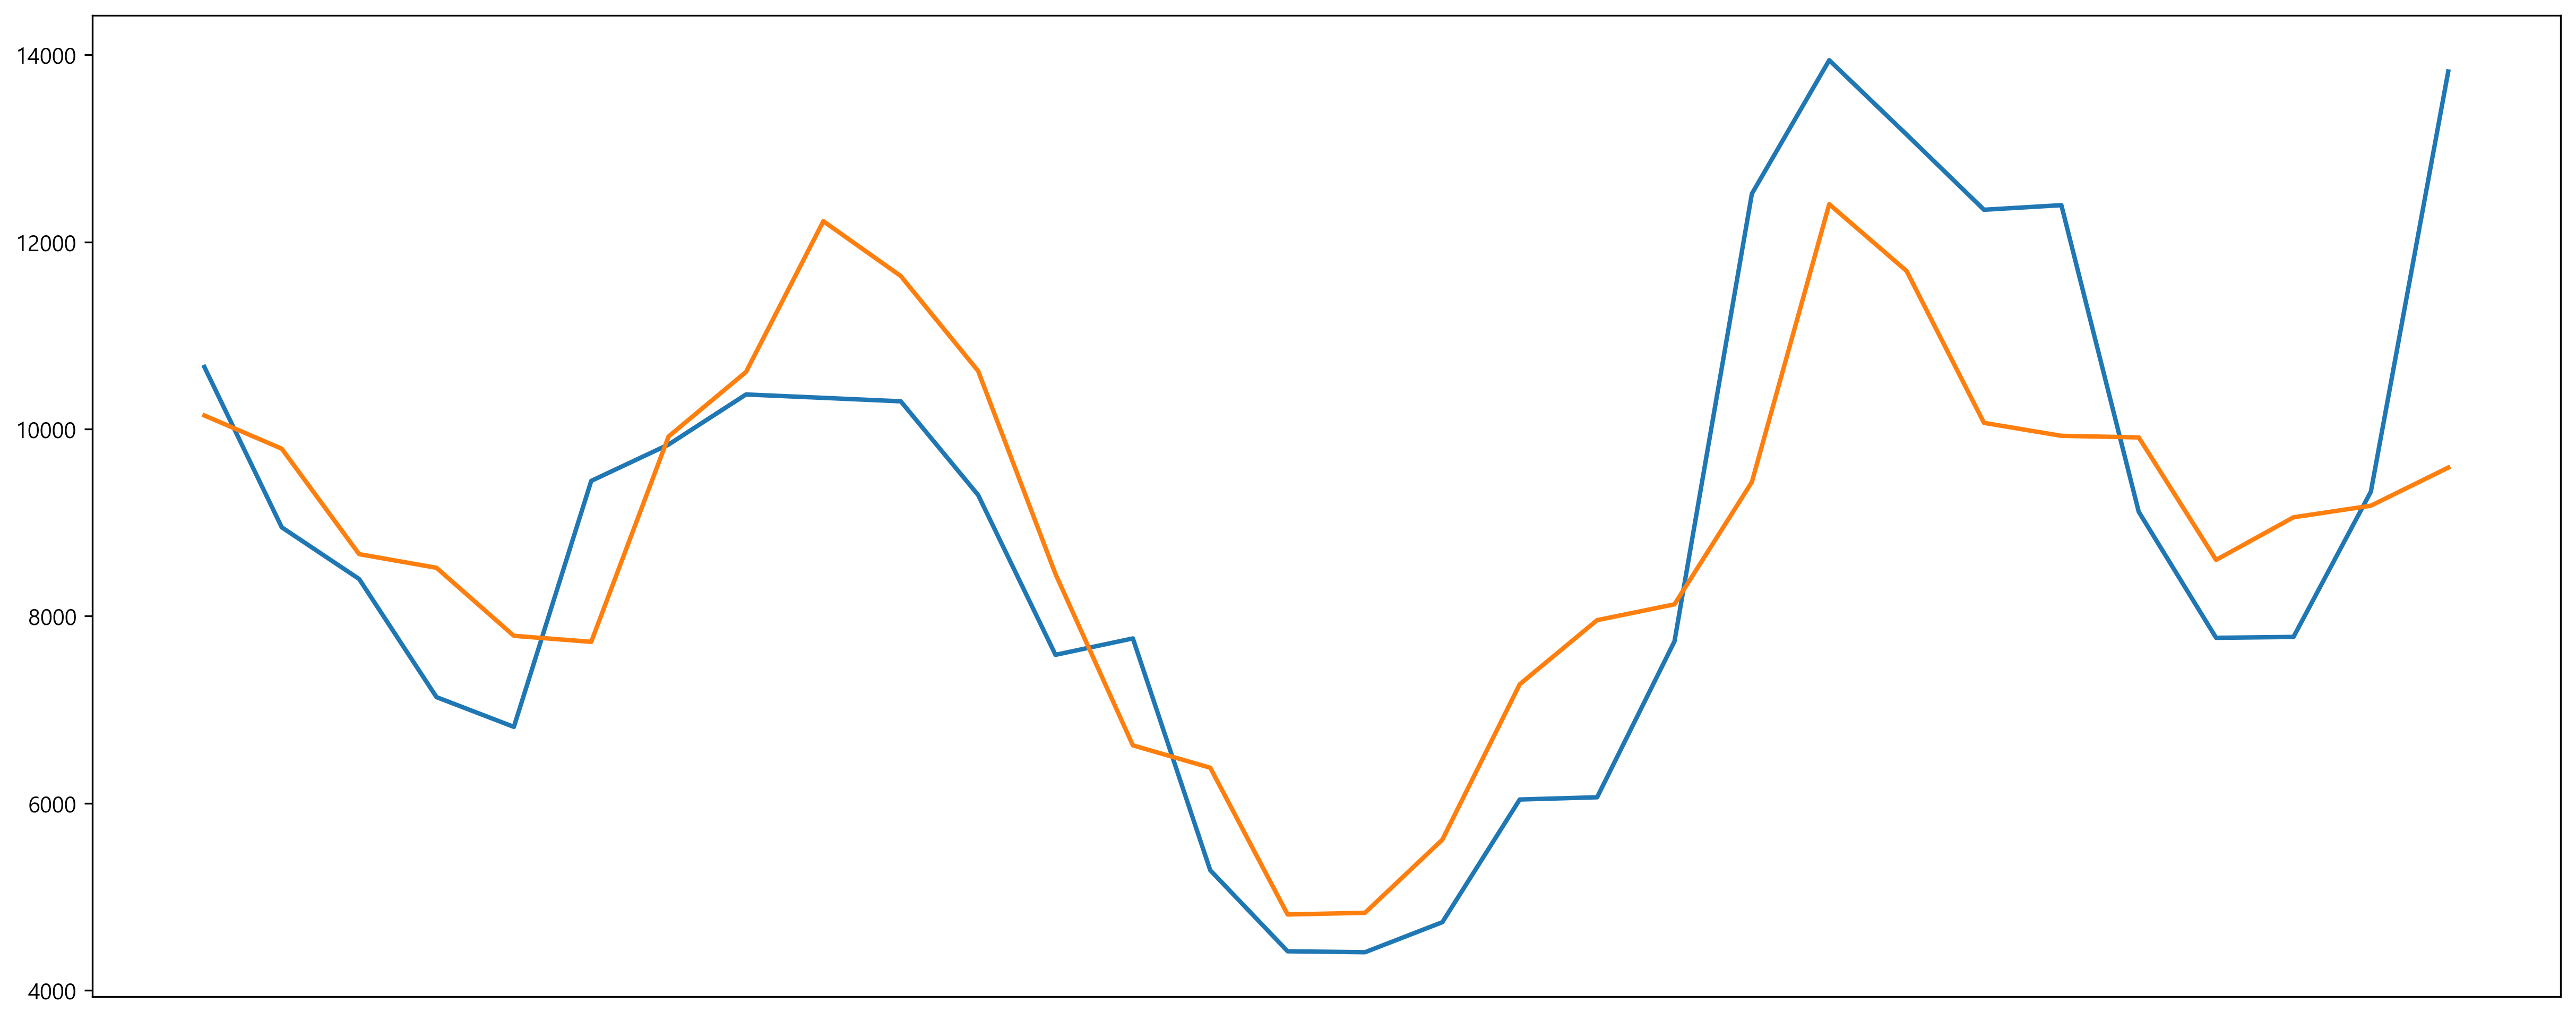

In [36]:
import matplotlib.pyplot as plt

y_test_ori = scaler_target.inverse_transform(y_test)
y_pred_ori = scaler_target.inverse_transform(y_pred)

plt.figure(figsize=(20, 8))
plt.xticks([])
plt.plot(df.index[train_size + seq_len:train_size + seq_len + 30], y_test_ori[:30])
plt.plot(df.index[train_size + seq_len:train_size + seq_len + 30], y_pred_ori[:30])
plt.show()